In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import gsw

In [9]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [10]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

### Configuration parameters

In [21]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5
g = 9.81

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.


### Load moment calculations

In [22]:
ds = xr.open_dataset("../../data/BBTRE-tracer/tracer_moments.nc")
ds_t = xr.open_dataset("../../data/BBTRE-tracer/time-approx_tracer_moments.nc")

In [23]:
# Observations from Ledwell 2021 (see table)
observed_moments = {
    "time": np.array([0., 14.*30.4*86400.]),
    "first": np.array([45.9510, 45.9582]),
    "second": np.array([0.03e-4, 4.4e-4])
}

first_moment_tendency = np.diff(observed_moments["first"]) / np.diff(observed_moments["time"]) # density
centered_second_moment_tendency = 0.5*np.diff(observed_moments["second"]) / np.diff(observed_moments["time"]) # density

k_Taylor = 4.4e-4 # m^2/s
k_omega = 2.2e-5 # m^2/s

N4_av = 1.3e-12 # s^-2
α_obs = gsw.density.alpha(34., 1., 4000.)
dTdz_sq = (N4_av/((g*α_obs)**2))

$b = g\alpha T = -\dfrac{g}{\rho_{0}} \delta\rho$

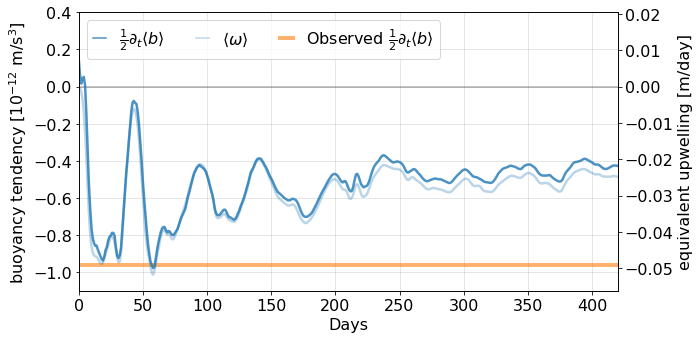

In [68]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax2 = ax.twinx()

ax.plot([],[],"C0-", label=r"$\frac{1}{2}\partial_{t} \langle b \rangle$", alpha=0.8)
ax.plot([],[],"C0-", alpha=0.3, label=r"$\langle \omega \rangle$")

ax.axhline(1e12*-g/ρ0*first_moment_tendency/2., label=r"Observed $\frac{1}{2}\partial_{t} \langle b \rangle$", color="C1", alpha=0.6, lw=4.)

ax.legend(loc="upper left", ncol=3, labelspacing=0.3, handlelength=0.8, fontsize=16)

ax.set_ylabel(r"buoyancy tendency [10$^{-12}$ m/s$^{3}$]")
ax.grid(True, alpha=0.4)
ax.axhline(0., color="k", alpha=0.3, lw=1.5)
ax.plot(1e12*g*α*ds[f"2ω_Tr01"]/2., lw=2.5, c="C0", ls="-", alpha=0.3)
ax.plot(1e12*g*α*ds[f"d(θbar)dt_Tr01"]/2., lw=2.5, c="C0", ls="-", alpha=0.8)
ax.set_ylim(-1.1, 0.4)
ax.set_xlim(0, 14*30)
ax.set_xlabel("Days")

ylims = ax.get_ylim()
ax2.set_ylim(ylims  / (1e12 * N**2) * 86400)
ax2.set_ylabel("equivalent upwelling [m/day]")

plt.tight_layout()
plt.savefig("../../figures/BBTRE-tracer/BBTRE_downwelling.png", bbox_inches="tight", dpi=200.)

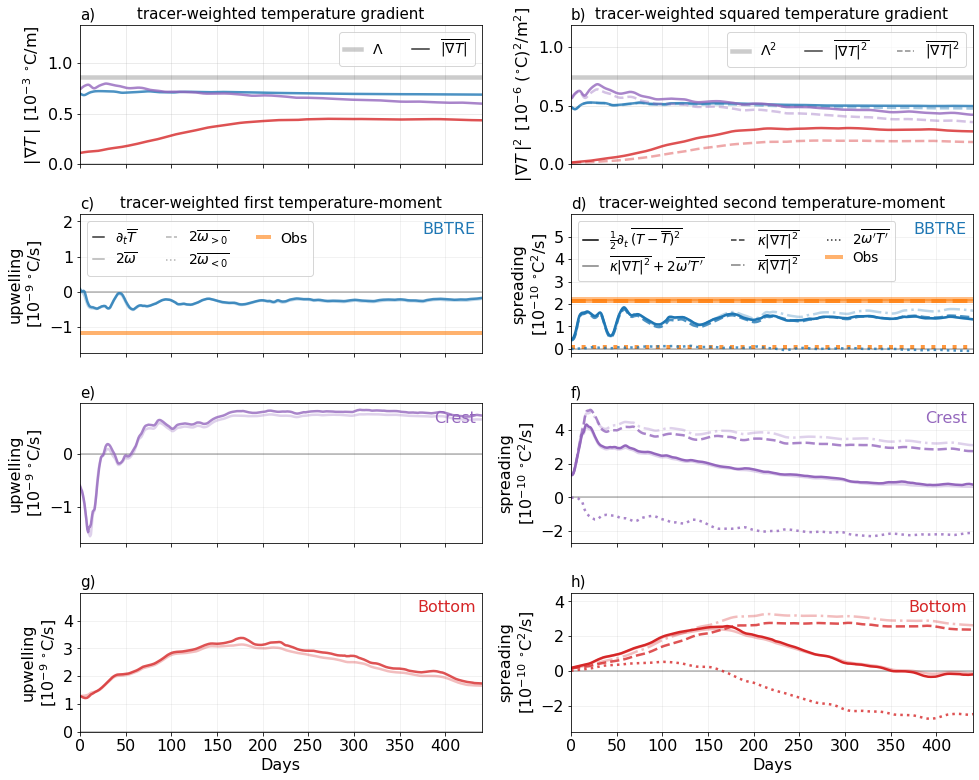

In [9]:
fig = plt.figure(figsize=(16,13))#, constrained_layout=True)
gs = fig.add_gridspec(4, 6, hspace=0.36, wspace=1.2)

tr_names = {1: "BBTRE", 2: "Crest", 3: "Bottom"}
tr_cols = {1: "C0", 2: "C4", 3: "C3"}

axes = {
    "Γ": [fig.add_subplot(gs[0, :3]), fig.add_subplot(gs[0, 3:])],
    "w": [fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[2, :3]), fig.add_subplot(gs[3, :3])],
    "κ": [fig.add_subplot(gs[1, 3:]), fig.add_subplot(gs[2, 3:]), fig.add_subplot(gs[3, 3:])],
}

ax = axes["Γ"][0]
ax.axhline(0., color="k", alpha=0.175, lw=1.5)
ax.axhline(1e3*Γ, color="k", alpha=0.2, lw=4.5, label=r"$\Lambda$", ls="-")
ax.plot([],[],"k-", label=r"$\overline{|\nabla T|}$", alpha=0.8)
ax.set_xticks(np.arange(0, 450, 50))
ax.set_xticklabels([])
ax.set_xlim(0, 440)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", ncol=2, labelspacing=0.4, handlelength=1.2, fontsize=14)

ax = axes["Γ"][1]
ax.axhline(0., color="k", alpha=0.175, lw=1.5)
ax.axhline(1e6*Γ**2, color="k", alpha=0.2, lw=4.5, label=r"$\Lambda^{2}$", ls="-")
ax.plot([],[],"k-", label=r"$\overline{|\nabla T|^{2}}$", alpha=0.75)
ax.plot([],[],"k--", label=r"$\overline{|\nabla T|}^{2}$", alpha=0.45)
ax.set_xticks(np.arange(0, 450, 50))
ax.set_xticklabels([])
ax.set_xlim(0, 440)
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", ncol=3, labelspacing=0.4, handlelength=1.2, fontsize=14)

for tr in [1,2,3]:
    ax = axes["Γ"][0]
    (1e3*ds[f"Gradθbar_Tr0{tr}"]).plot(ax=ax, lw=2.5, c=tr_cols[tr], ls="-", alpha=0.8, x="days")
    ax.set_ylabel(r"$|\, \nabla T\, |\,$ [$10^{-3}$ $^{\circ}$C/m]")
    ax.set_xlabel("")

    ax = axes["Γ"][1]
    (1e6*ds[f"Gradθ**2bar_Tr0{tr}"]).plot(ax=ax, lw=2.5, c=tr_cols[tr], ls="-", alpha=0.8, x="days")
    (1e6*ds[f"Gradθbar_Tr0{tr}"]**2).plot(ax=ax, lw=2.5, c=tr_cols[tr], ls="--", alpha=0.4, x="days")
    ax.set_ylabel(r"$|\, \nabla T \,|^{2}\,$ [$10^{-6}$ ($^{\circ}$C)$^{2}$/m$^{2}$]")
    ax.set_xlabel("")
    
### w
ax = axes["w"][0]
ax.plot([],[],"k-", label=r"$\partial_{t} \overline{T}$", alpha=0.8)
ax.plot([],[],"k-", alpha=0.3, label=r"$2\overline{\omega}$")
ax.plot([],[],"k--", alpha=0.3, label=r"$2\overline{\omega_{>0}}$")
ax.plot([],[],"k:", alpha=0.3, label=r"$2\overline{\omega_{<0}}$")

ax.axhline(1e9*first_moment_tendency/(-ρ0*α_obs)/obs_scale, label=f"Obs", color="C1", alpha=0.6, lw=4.)

ax.legend(loc="upper left", ncol=3, labelspacing=0.3, handlelength=0.8, fontsize=14)

for tr in [1,2,3]:
    ax = axes["w"][tr-1]
    ax.grid(True, alpha=0.2)
    ax.axhline(0., color="k", alpha=0.3, lw=1.5)
    ax.plot(1e9*ds[f"2ω_Tr0{tr}"]/2., lw=2.5, c=tr_cols[tr], ls="-", alpha=0.3)
    ax.plot(1e9*ds[f"d(θbar)dt_Tr0{tr}"]/2., lw=2.5, c=tr_cols[tr], ls="-", alpha=0.8)
    ax.set_xlim(0, 440)
    ax.set_ylabel("upwelling\n"+r"[$10^{-9}$ $^{\circ}$C/s]")
    ax.annotate(tr_names[tr], xy=(0.985, 0.86), xycoords="axes fraction", color=tr_cols[tr], horizontalalignment="right")
    if tr in [1,2]:
        ax.set_xticks(np.arange(0, 450, 50))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(0, 450, 50))
ax.set_xlabel("Days")

### k
ax = axes["κ"][0]
ax.plot([],[],"k-", label=r"$\frac{1}{2}\partial_{t}\, \overline{(T - \overline{T})^{2}}$")
ax.plot([],[],"k-", alpha=0.5, label=r"$\overline{\kappa |\nabla T|^{2}} + 2 \overline{\omega' T'}$")
ax.plot([],[],"k--", alpha=0.8, label=r"$\overline{\kappa |\nabla T|^{2}}$")
ax.plot([],[],"k-.", alpha=0.5, label=r"$\overline{\kappa} \overline{|\nabla T|^{2}}$")
ax.plot([],[],"k:", alpha=0.8, label=r"$2 \overline{\omega' T'}$")

ax.axhline(1e10*centered_second_moment_tendency/(-ρ0*α_obs)**2/obs_scale, label=f"Obs", color="C1", alpha=0.6, lw=4.)
ax.axhline(1e10*(k_Taylor+k_omega)*dTdz_sq/obs_scale, ls="-", color="C1", alpha=0.5, lw=4.)
ax.axhline(1e10*k_Taylor*dTdz_sq/obs_scale, ls="--", color="C1", alpha=0.8, lw=4.)
ax.axhline(1e10*k_omega*dTdz_sq/obs_scale, ls=":", color="C1", alpha=0.8, lw=4.)

ax.legend(loc="upper left", ncol=3, labelspacing=0.175, handlelength=1.1, fontsize=13.5)

for tr in [1,2,3]:
    ax = axes["κ"][tr-1]
    ax.grid(True, alpha=0.2)
    ax.axhline(0., color="k", alpha=0.3, lw=1.5)
    ax.plot(1e10*(ds[f"κGradθ**2bar_Tr0{tr}"]+2*ds[f"_(ωpθp)bar_Tr0{tr}"]), lw=2.5, c=tr_cols[tr], ls="-", alpha=0.3)
    ax.plot(1e10*0.5*ds[f'd((θ-θbar)**2)bardt_Tr0{tr}'], lw=2.5, c=tr_cols[tr], ls="-")
    ax.plot(1e10*ds[f"κGradθ**2bar_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="--", alpha=0.8)
    ax.plot(1e10*ds[f"κbar_Tr0{tr}"]*ds[f"Gradθ**2bar_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="-.", alpha=0.3)
    ax.plot(1e10*2*ds[f"_(ωpθp)bar_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls=":", alpha=0.8)
    ax.set_xlim(0, 440)
    #ax.set_ylim(2e5*-10*k0, 1e5*1.1*k1)
    ax.set_ylabel("spreading\n"+r"[10$^{-10}$ $^{\circ}$C$^{2}$/s]")
    ax.annotate(tr_names[tr], xy=(0.985, 0.86), xycoords="axes fraction", color=tr_cols[tr], horizontalalignment="right")
    if tr in [1,2]:
        ax.set_xticks(np.arange(0, 450, 50))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(0, 450, 50))
ax.set_xlabel("Days")

#plt.tight_layout()

axes["Γ"][0].set_yticks(np.arange(0, 1.5, 0.5))
axes["Γ"][0].set_ylim(0, 1.6*1e3*Γ)
axes["Γ"][1].set_yticks(np.arange(0, 2, 0.5))
axes["Γ"][1].set_ylim(0, 1.6*1e6*(Γ**2))

axes["w"][0].set_yticks(np.arange(-1, 3, 1))
axes["w"][0].set_ylim(-1.75, 2.2)
#axes["w"][1].set_yticks(np.arange(-10, 20, 5))
#axes["w"][1].set_ylim(-12, 12)
axes["w"][2].set_yticks(np.arange(0, 5, 1))
axes["w"][2].set_ylim(0, 5)

axes["κ"][0].set_yticks(np.arange(0, 6, 1))
axes["κ"][0].set_ylim(-0.2, 6)
axes["κ"][1].set_yticks(np.arange(-2, 6, 2))
#axes["κ"][1].set_ylim(-100, 120)
axes["κ"][2].set_yticks(np.arange(-2, 6, 2))
axes["κ"][2].set_ylim(-3.5, 4.5)

axes["Γ"][0].set_title("tracer-weighted temperature gradient", fontsize=15)
axes["Γ"][1].set_title("tracer-weighted squared temperature gradient", fontsize=15)

axes["w"][0].set_title("tracer-weighted first temperature-moment", fontsize=15)
axes["κ"][0].set_title("tracer-weighted second temperature-moment", fontsize=15)

axes["Γ"][0].set_title("a)", loc="left", fontsize=15)
axes["Γ"][1].set_title("b)", loc="left", fontsize=15)
axes["w"][0].set_title("c)", loc="left", fontsize=15)
axes["κ"][0].set_title("d)", loc="left", fontsize=15)
axes["w"][1].set_title("e)", loc="left", fontsize=15)
axes["κ"][1].set_title("f)", loc="left", fontsize=15)
axes["w"][2].set_title("g)", loc="left", fontsize=15)
axes["κ"][2].set_title("h)", loc="left", fontsize=15)

plt.savefig("../../figures/BBTRE-tracer/tracer_moments.png", bbox_inches="tight", dpi=200.)

In [288]:
κobs = (centered_second_moment_tendency/(-ρ0*α_obs)**2)/dTdz_sq

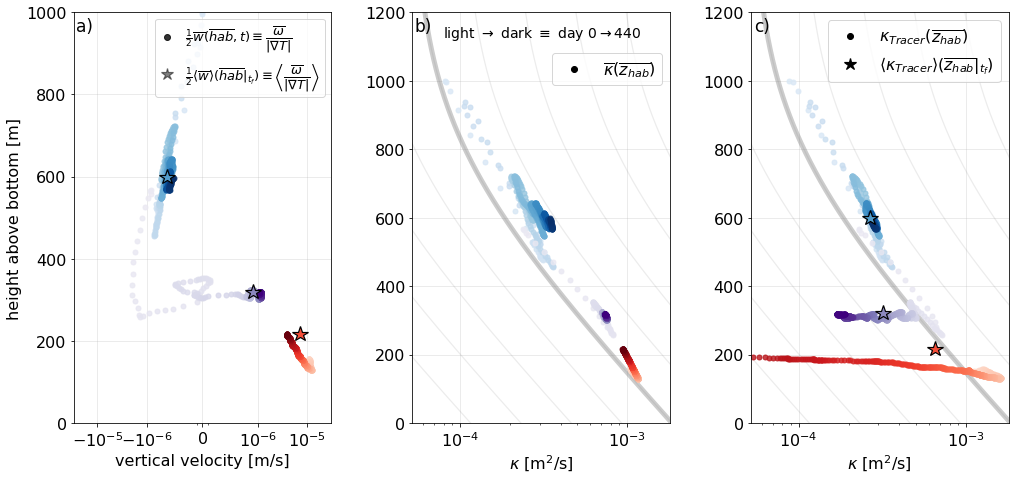

In [289]:
fig = plt.figure(figsize=(14,6.5), constrained_layout=True)
gs = fig.add_gridspec(1, 3, hspace=0.36, wspace=0.1)

axes = {
    "hab": [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])],
}



### hab
nt = 440
zplot = np.arange(0, 1500., 1.)

cmaps = [
    None,
    matplotlib.cm.get_cmap("Blues"),
    matplotlib.cm.get_cmap("Purples"),
    matplotlib.cm.get_cmap("Reds")
]

Ly = 600.*100.
wmt = xr.open_dataset("../../data/BBTRE-physics/wmt_total.nc")

#
ax = axes["hab"][0]
ax.grid(True, alpha=0.3)
w_hab = (wmt["E_hab"]/wmt["dZ_habC_bin"]).mean("time")*(np.sin(θ)/Ly)
#w_hab.plot(ax=ax, y="Z_habC_bin", lw=5., color="grey", alpha=0.4, label=r"$\dfrac{\sin{\theta}}{L_{y}} \; \dfrac{\partial \mathcal{E}}{\partial (hab)}$")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.plot(
            (0.5*ds[f'2ω_Tr0{tr}'][t])/(ds[f'Gradθbar_Tr0{tr}'][t]),
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8
        )
for tr in [1,2,3]:
    ax.plot(
        ((0.5*ds[f'2ω_Tr0{tr}'])/ds[f'Gradθbar_Tr0{tr}']).isel(time=slice(0, nt)).mean(),
        ds[f'HABbar_Tr0{tr}'][nt],
        color=cmaps[tr](0.15+0.85*ds['days'][nt//2].values/nt),
        marker="*",
        markersize=16,
        markeredgecolor="k",
        markeredgewidth=1.2,
        alpha=1.
    )
ax.plot([], [], "ko", alpha=0.8, label=r"$\frac{1}{2}\overline{w}(\overline{hab}, t) \equiv \dfrac{\overline{\omega}}{|\nabla T|}$")
ax.plot([], [], "k*", alpha=0.5,
        label=r"$\frac{1}{2}\langle \overline{w} \rangle (\overline{hab}|_{t_{f}}) \equiv \left\langle \dfrac{ \overline{\omega}}{|\nabla T|} \right\rangle$",
        markersize=12, markeredgecolor="k", markeredgewidth=1.2)
ax.set_xscale('symlog', linthresh=1e-7, linscale=0.1)
ax.set_xticks([-1e-5, -1e-6, 0, 1e-6, 1e-5])
ax.set_ylim(0, 1000)
ax.set_xlim(-3e-5, 3e-5)
ax.set_title("")
ax.legend(handlelength=1.1, loc="upper right", fontsize=13)
ax.set_ylabel("height above bottom [m]")
ax.set_xlabel("vertical velocity [m/s]")

# k
ax = axes["hab"][1]
ax.grid(True, alpha=0.3)
ax.semilogx(k0+k1*np.exp(-zplot/h), zplot, lw=5, c="grey", alpha=0.4)
for power in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
    ax.semilogx((2**power)*(k0+k1*np.exp(-zplot/h)), zplot, lw=1.25, c="grey", alpha=0.15)
ax.set_title("")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.semilogx(
            ds[f'κbar_Tr0{tr}'][t],
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8,
        )
ax.plot([], [], "ko", label=r"$\overline{κ}(\overline{z_{hab}})$")
ax.set_xlim(k0, k1)
ax.set_ylim(0, 1200)
ax.set_xlabel(r"$κ$ [m$^{2}$/s]")
ax.annotate(r"light $\rightarrow$ dark $\equiv$ day $0 \rightarrow 440$", xy=(0.12, 0.94), xycoords="axes fraction", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(0., 0., 1.0, 0.92))

ax = axes["hab"][2]
ax.grid(True, alpha=0.3)
ax.semilogx(k0+k1*np.exp(-zplot/h), zplot, lw=5, c="grey", alpha=0.4)
for power in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
    ax.semilogx((2**power)*(k0+k1*np.exp(-zplot/h)), zplot, lw=1.25, c="grey", alpha=0.15)
ax.set_title("")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.semilogx(
            ds[f'κTracer_Tr0{tr}'][t],
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8
        )
for tr in [1,2,3]:
    ax.plot(
        ds[f'κTracer_Tr0{tr}'].isel(time=slice(0, nt)).mean(),
        ds[f'HABbar_Tr0{tr}'][nt],
        color=cmaps[tr](0.15+0.85*ds['days'][nt//2].values/nt),
        marker="*",
        markersize=16,
        markeredgecolor="k",
        markeredgewidth=1.2,
        alpha=1.
    )
ax.plot([], [], "ko", label=r"$κ_{Tracer}(\overline{z_{hab}})$")
ax.plot([], [], "k*", label=r"$\langle κ_{Tracer} \rangle (\overline{z_{hab}}|_{t_{f}})$",
        markersize=12, markeredgecolor="k", markeredgewidth=1.2)
ax.set_xlim(k0, k1)
ax.set_ylim(0, 1200)
ax.set_xlabel(r"$κ$ [m$^{2}$/s]")
ax.legend(loc="upper right")

axes["hab"][0].set_title("a)", loc="left", x=0.01,  y=0.94, fontsize=17)
axes["hab"][1].set_title("b)", loc="left", x=0.01,  y=0.94, fontsize=17)
axes["hab"][2].set_title("c)", loc="left", x=0.01, y=0.94, fontsize=17)

plt.savefig("../../figures/BBTRE-tracer/tracer_moments_hab.png", bbox_inches="tight", dpi=200.)

In [290]:
z_hab = w_hab['Z_habC_bin']

def H(z, z0, h, option="box"):
    if option=="box":
        return np.logical_and(z >= z0-h/2, z < z0+h/2)
    elif option=="gauss":
        return np.exp(-(z - z0)**2/((h/2)**2))
    elif option=="exp":
        return np.exp(-np.abs((z-z0)/(h/2)))

In [291]:
def w_hab_convolve(w, z, h, option="box"):
    dz = z.diff("Z_habC_bin")
    w_bar, z_bar = xr.zeros_like(z), xr.zeros_like(z)
    for (k, z0) in enumerate(z):
        w_bar[k] = (dz*H(z, z0, h, option=option)*w).sum("Z_habC_bin") / (dz*H(z, z0, h, option=option)).sum("Z_habC_bin")
        z_bar[k] = (dz*H(z, z0, h, option=option)*z).sum("Z_habC_bin") / (dz*H(z, z0, h, option=option)).sum("Z_habC_bin")
    return w_bar, z_bar

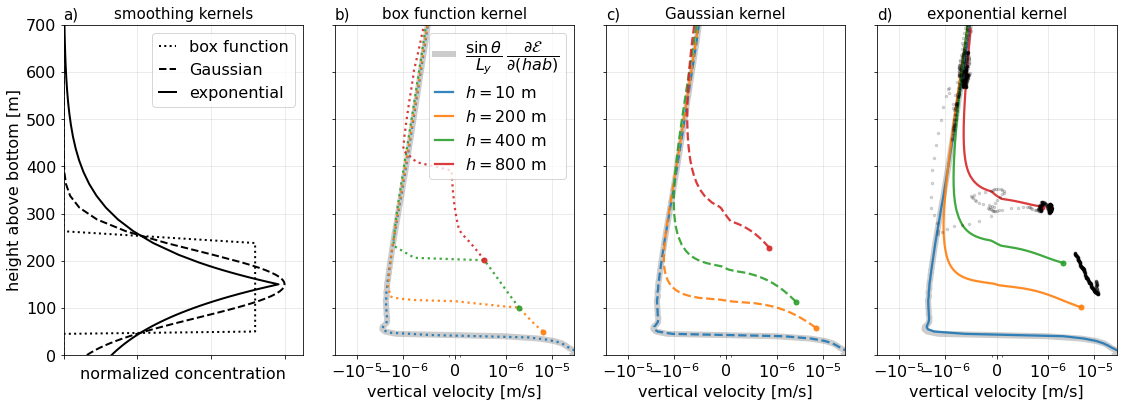

In [295]:
fig = plt.figure(figsize=(15.5,5.5), constrained_layout=True)
gs = fig.add_gridspec(1, 4, hspace=0.36, wspace=0.1)

axes = {
    "hab": [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 3])],
}

panel_labels = ["a)", "b)", "c)", "d)"]

options = ["box", "gauss", "exp"]
long_options = ["box function", "Gaussian", "exponential"]
linestyles = [":", "--", "-"]

ax=axes["hab"][0]
ax.grid(True, alpha=0.3)
    
dz_hab = z_hab.diff("Z_habC_bin")
z0 = 150
h = 200

for option, long_option, linestyle in zip(options, long_options, linestyles):
    (H(z_hab, z0, h, option=option)/(dz_hab*H(z_hab, z0, h, option=option)).sum("Z_habC_bin")).plot(ax=ax, y="Z_habC_bin", color="k", linestyle=linestyle, lw=2., label=long_option)
ax.set_xlim(0, 0.0065)
ax.set_ylim(0, 700)
ax.set_xticklabels([])
ax.set_xlabel("normalized concentration")
ax.set_ylabel("height above bottom [m]")
ax.set_title("smoothing kernels", fontsize=15)
ax.set_title(f"{panel_labels[0]}", loc="left", fontsize=15)
ax.legend(handlelength=1.1, loc="upper right", fontsize=16)

colors = ["C0", "C1", "C2", "C3"]
for panel, option in enumerate(options, start=1):
    ax = axes["hab"][panel]
    ax.grid(True, alpha=0.3)
    label = r"$\dfrac{\sin{\theta}}{L_{y}} \; \dfrac{\partial \mathcal{E}}{\partial (hab)}$"
    if panel>1:
        label=None
    w_hab.plot(ax=ax, y="Z_habC_bin", lw=6., color="grey", alpha=0.4, label=label)

    for hidx, h in enumerate([10, 200, 400, 800]):
        
        label = fr"$h = {h}$ m"
        if panel>1:
            label=None
        
        wbar, zbar = w_hab_convolve(w_hab, zhab, h, option=option)
        ax.plot(wbar, zbar, lw=2.25, alpha=0.9, color=colors[hidx], linestyle=linestyles[panel-1])
        ax.plot([wbar[0]], [zbar[0]], lw=2.25, alpha=0.9, color=colors[hidx], marker="o", markersize=5)
        ax.plot([], [], lw=2.25, alpha=0.9, color=colors[hidx], linestyle="-", label=label)

    ax.set_xscale('symlog', linthresh=1e-7, linscale=0.1)
    ax.set_xticks([-1e-5, -1e-6, 0, 1e-6, 1e-5])
    ax.set_ylim(0, 700)
    ax.set_xlim(-3e-5, 3e-5)
    ax.set_title("")
    if panel==1:
        ax.legend(handlelength=1.1, loc="upper right", fontsize=16)
    ax.set_yticklabels([])
    ax.set_ylabel("")
    ax.set_xlabel("vertical velocity [m/s]")
    ax.set_title(f"{long_options[panel-1]} kernel", fontsize=15)
    ax.set_title(f"{panel_labels[panel]}", loc="left", fontsize=15)
    
ax = axes["hab"][3]
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.plot(
            (0.5*ds[f'2ω_Tr0{tr}'][t])/(ds[f'Gradθbar_Tr0{tr}'][t]),
            ds[f'HABbar_Tr0{tr}'][t],
            color="k",
            markersize=5,
            marker=".",
            alpha=0.15
        )
    
plt.savefig("../../figures/BBTRE-tracer/w_smoothing_kernels.png", bbox_inches="tight", dpi=200.)

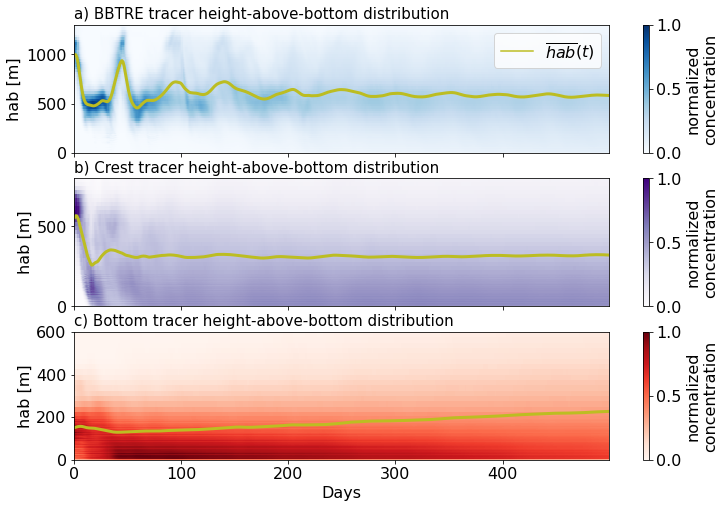

In [293]:
fig, axes = plt.subplots(3, 1, figsize=(12,8))
ymax = [1300, 800, 600]
colors = ["Blues", "Purples", "Reds"]

for tr in [1,2,3]:
    ax = axes[tr-1]
    c_hab = ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]
    c_hab /= c_hab.max()
    PC = c_hab.plot(ax=ax, x="days", cmap=colors[tr-1], vmin=0, vmax=1, extend="neither")
    PC.colorbar.set_label("normalized\nconcentration")
    ds[f"HABbar_Tr0{tr}"].plot(ax=ax, x="days", color="C8", lw=3., alpha=1.)
    ax.set_ylim(0, ymax[tr-1])
    ax.set_ylabel("hab [m]")
    ax.set_xlabel("")
    ax.set_xticks(np.arange(0,500,100))
    ax.set_xticklabels([])

ax = axes[0]
ax.set_title("a) BBTRE tracer height-above-bottom distribution", loc="left", fontsize=15)
ax.plot([], [], "-C8", label=r"$\overline{hab}(t)$")
ax.legend(loc="upper right")
ax = axes[1]
ax.set_title("b) Crest tracer height-above-bottom distribution", loc="left", fontsize=15)
ax = axes[2]
ax.set_title("c) Bottom tracer height-above-bottom distribution", loc="left", fontsize=15)
ax.set_xticks(np.arange(0,500,100))
ax.set_xticklabels(np.arange(0,500,100))
ax.set_xlabel("Days")

plt.savefig("../../figures/BBTRE-tracer/S_hab-distribution.png", bbox_inches="tight", dpi=200.)

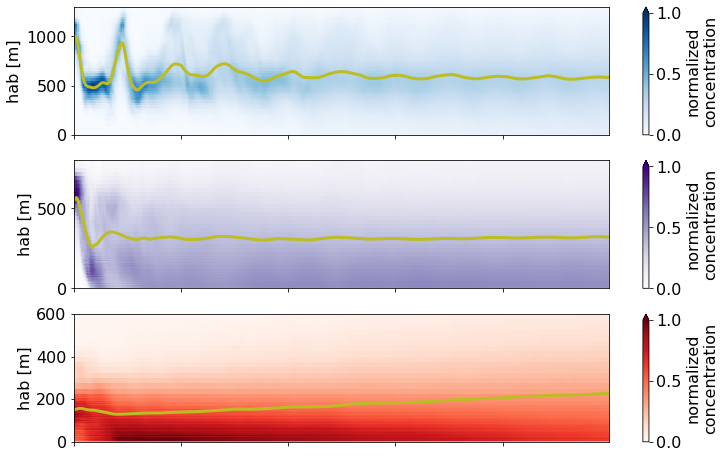

In [269]:
plt.figure(figsize=(12,8))
ymax = [1300, 800, 600]
colors = ["Blues", "Purples", "Reds"]

for tr in [1,2,3]:
    plt.subplot(3,1,tr)
    c_hab = ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]
    c_hab /= c_hab.max()
    PC = c_hab.plot(x="days", cmap=colors[tr-1], vmin=0, vmax=1, extend="max")
    PC.colorbar.set_label("normalized\nconcentration")
    ds[f"HABbar_Tr0{tr}"].plot(x="days", color="C8", lw=3., alpha=1.)
    plt.ylim(0, ymax[tr-1])
    plt.ylabel("hab [m]")
    plt.xlabel("")
    plt.xticks(np.arange(0,500,100), [])


In [ ]:
fig = plt.figure(figsize=(16,16))#, constrained_layout=True)
gs = fig.add_gridspec(5, 6, hspace=0.36, wspace=1.2)

tr_names = {1: "BBTRE", 2: "Crest", 3: "Bottom"}
tr_cols = {1: "C0", 2: "C4", 3: "C3"}

axes = {
    "w": [fig.add_subplot(gs[0, :3]), fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[2, :3])],
    "κ": [fig.add_subplot(gs[0, 3:]), fig.add_subplot(gs[1, 3:]), fig.add_subplot(gs[2, 3:])],
    "hab": [fig.add_subplot(gs[3:, 0:2]), fig.add_subplot(gs[3:, 2:4]), fig.add_subplot(gs[3:, 4:6])]
}

### w
ax = axes["w"][0]
ax.plot([],[],"k-", label=r"$w_{Tracer}$", alpha=0.8)
ax.plot([],[],"k-", alpha=0.3, label=r"$2\overline{\omega}\; / \;\left| \overline{\nabla b} \right|$")
ax.plot([],[],"k--", alpha=0.3, label=r"$2\overline{\omega_{>0}}\; / \;\left| \overline{\nabla b} \right|$")
ax.plot([],[],"k:", alpha=0.3, label=r"$2\overline{\omega_{<0}}\; / \;\left| \overline{\nabla b} \right|$")
ax.legend(loc="upper left", ncol=2, labelspacing=0.3, handlelength=0.8, fontsize=14)

for tr in [1,2,3]:
    ax = axes["w"][tr-1]
    ax.grid(True, alpha=0.2)
    ax.axhline(0., color="k", alpha=0.3, lw=1.5)
    ax.plot(ds[f"2ω_Tr0{tr}"]/ds[f"Gradθbar_Tr0{tr}"]*1e6, lw=2.5, c=tr_cols[tr], ls="-", alpha=0.3)
    ax.plot(2*ds[f"ωbar_BBL_Tr0{tr}"]/ds[f"Gradθbar_Tr0{tr}"]*1e6, lw=2.5, c=tr_cols[tr], ls="--", alpha=0.5)
    ax.plot(2*ds[f"ωbar_SML_Tr0{tr}"]/ds[f"Gradθbar_Tr0{tr}"]*1e6, lw=2.5, c=tr_cols[tr], ls=":", alpha=0.5)
    ax.plot(ds[f"d(θbar)dt_Tr0{tr}"]/ds[f"Gradθbar_Tr0{tr}"]*1e6, lw=2.5, c=tr_cols[tr], ls="-", alpha=0.8)
    ax.set_xlim(0, 440)
    ax.set_ylabel(r"$w$ [10$^{-6}$ m/s]")
    ax.annotate(tr_names[tr], xy=(0.985, 0.86), xycoords="axes fraction", color=tr_cols[tr], horizontalalignment="right")
    if tr in [1,2]:
        ax.set_xticks(np.arange(0, 450, 50))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(0, 450, 50))
ax.set_xlabel("Days")

### k
ax = axes["κ"][0]
ax.plot([],[],"k-", label=r"$\kappa_{Tracer}$")
ax.plot([],[],"k-", alpha=0.5, label=r"$κ_{Taylor} + κ_{ω}$")
ax.plot([],[],"k-", alpha=0.5, label="")
ax.plot([],[],"k--", alpha=0.8, label=r"$κ_{Taylor}$")
ax.plot([],[],"k-.", alpha=0.5, label=r"$\overline{κ}$")
ax.plot([],[],"k:", alpha=0.8, label=r"$κ_{ω}$")
ax.legend(loc="upper left", ncol=3, labelspacing=0.4, handlelength=1.5, fontsize=14)

for tr in [1,2,3]:
    ax = axes["κ"][tr-1]
    ax.grid(True, alpha=0.2)
    ax.axhline(0., color="k", alpha=0.3, lw=1.5)
    ax.plot(1e4*(ds[f"κTaylor_Tr0{tr}"]+ds[f"κOmega_Tr0{tr}"]), lw=2.5, c=tr_cols[tr], ls="-", alpha=0.3)
    ax.plot(1e4*ds[f"κTracer_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="-")
    ax.plot(1e4*ds[f"κTaylor_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="--", alpha=0.8)
    ax.plot(1e4*ds[f"κbar_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls="-.", alpha=0.3)
    ax.plot(1e4*ds[f"κOmega_Tr0{tr}"], lw=2.5, c=tr_cols[tr], ls=":", alpha=0.8)
    ax.set_xlim(0, 440)
    ax.set_ylim(2e4*-10*k0, 1e4*1.1*k1)
    ax.set_ylabel(r"$κ$ [10$^{-4}$ m$^{2}/s$]")
    ax.annotate(tr_names[tr], xy=(0.985, 0.86), xycoords="axes fraction", color=tr_cols[tr], horizontalalignment="right")
    if tr in [1,2]:
        ax.set_xticks(np.arange(0, 450, 50))
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(0, 450, 50))
ax.set_xlabel("Days")

### hab
nt = 440
zplot = np.arange(0, 1500., 1.)

cmaps = [
    None,
    matplotlib.cm.get_cmap("Blues"),
    matplotlib.cm.get_cmap("Purples"),
    matplotlib.cm.get_cmap("Reds")
]

Ly = 600.*100.
wmt = xr.open_dataset("../../data/BBTRE-physics/wmt_total.nc")

#
ax = axes["hab"][0]
ax.grid(True, alpha=0.3)
w_hab = (wmt["E_hab"]/wmt["dZ_habC_bin"]).mean("time")*(np.sin(θ)/Ly)
w_hab.plot(ax=ax, y="Z_habC_bin", lw=5., color="grey", alpha=0.4, label=r"$\frac{\sin{\theta}}{L_{y}} \dfrac{\partial \mathcal{E}}{\partial (hab)}$")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.plot(
            (ds[f'2ω_Tr0{tr}'][t]/2)/(ds[f'Gradθbar_Tr0{tr}'][t]),
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8
        )
for tr in [1,2,3]:
    ax.plot(
        ((ds[f'2ω_Tr0{tr}']/2)/ds[f'Gradθbar_Tr0{tr}']).isel(time=slice(0, nt)).mean(),
        ds[f'HABbar_Tr0{tr}'][nt],
        color=cmaps[tr](0.15+0.85*ds['days'][nt//2].values/nt),
        marker="*",
        markersize=16,
        markeredgecolor="k",
        markeredgewidth=1.2,
        alpha=1.
    )
ax.plot([], [], "ko", alpha=0.8, label=r"$\frac{1}{2}\overline{w}(\overline{hab}, t) \equiv \dfrac{\overline{\omega}}{|\nabla b|}$")
ax.plot([], [], "k*", alpha=0.5,
        label=r"$\frac{1}{2}\langle \overline{w} \rangle (\overline{hab}|_{t_{f}}) \equiv \left\langle\dfrac{\overline{\omega}}{|\nabla b|}\right\rangle$",
        markersize=12, markeredgecolor="k", markeredgewidth=1.2)
ax.set_xscale('symlog', linthresh=1e-7, linscale=0.1)
ax.set_xticks([-1e-5, -1e-6, 0, 1e-6, 1e-5])
ax.set_ylim(0, 1000)
ax.set_xlim(-3e-5, 3e-5)
ax.set_title("")
ax.legend(handlelength=1.1, loc="upper right", fontsize=13)
ax.set_ylabel("height above bottom [m]")
ax.set_xlabel("vertical velocity [m/s]")

#
ax = axes["hab"][1]
ax.grid(True, alpha=0.3)
ax.semilogx(k0+k1*np.exp(-zplot/h), zplot, lw=5, c="grey", alpha=0.4)
for power in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
    ax.semilogx((2**power)*(k0+k1*np.exp(-zplot/h)), zplot, lw=1.25, c="grey", alpha=0.15)
ax.set_title("")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.semilogx(
            ds[f'κbar_Tr0{tr}'][t],
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8,
        )
ax.plot([], [], "ko", label=r"$\overline{κ}(\overline{z_{hab}})$")
ax.set_xlim(k0, k1)
ax.set_ylim(0, 1200)
ax.set_xlabel(r"$κ$ [m$^{2}$/s]")
ax.annotate(r"light $\rightarrow$ dark $\equiv$ day $0 \rightarrow 440$", xy=(0.12, 0.94), xycoords="axes fraction", fontsize=14)
ax.legend(loc="upper right", bbox_to_anchor=(0., 0., 1.0, 0.92))

ax = axes["hab"][2]
ax.grid(True, alpha=0.3)
ax.semilogx(k0+k1*np.exp(-zplot/h), zplot, lw=5, c="grey", alpha=0.4)
for power in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
    ax.semilogx((2**power)*(k0+k1*np.exp(-zplot/h)), zplot, lw=1.25, c="grey", alpha=0.15)
ax.set_title("")
for tr in [1,2,3]:
    for t in range(0, nt):
        ax.semilogx(
            ds[f'κTracer_Tr0{tr}'][t],
            ds[f'HABbar_Tr0{tr}'][t],
            color=cmaps[tr](0.15+0.85*ds['days'][t].values/nt),
            markersize=5,
            marker="o",
            alpha=0.8
        )
for tr in [1,2,3]:
    ax.plot(
        ds[f'κTracer_Tr0{tr}'].isel(time=slice(0, nt)).mean(),
        ds[f'HABbar_Tr0{tr}'][nt],
        color=cmaps[tr](0.15+0.85*ds['days'][nt//2].values/nt),
        marker="*",
        markersize=16,
        markeredgecolor="k",
        markeredgewidth=1.2,
        alpha=1.
    )
ax.plot([], [], "ko", label=r"$κ_{Tracer}(\overline{z_{hab}})$")
ax.plot([], [], "k*", label=r"$\langle κ_{Tracer} \rangle (\overline{z_{hab}}|_{t_{f}})$",
        markersize=12, markeredgecolor="k", markeredgewidth=1.2)
ax.set_xlim(k0, k1)
ax.set_ylim(0, 1200)
ax.set_xlabel(r"$κ$ [m$^{2}$/s]")
ax.legend(loc="upper right")

#plt.tight_layout()

axes["w"][0].set_yticks(np.arange(-2, 4, 1))
axes["w"][0].set_ylim(-2.25, 3.75)
axes["w"][1].set_yticks(np.arange(-10, 20, 5))
axes["w"][1].set_ylim(-12, 12)
axes["w"][2].set_yticks(np.arange(-10, 30, 10))
axes["w"][2].set_ylim(-10, 25)

axes["κ"][0].set_yticks(np.arange(0, 12, 2))
axes["κ"][0].set_ylim(-0.5, 10)
axes["κ"][1].set_yticks(np.arange(-10, 15, 5))
axes["κ"][1].set_ylim(-10, 12)
axes["κ"][2].set_yticks(np.arange(-10, 20, 5))
axes["κ"][2].set_ylim(-10, 18)

axes["w"][0].set_title("tracer-weighted first buoyancy-moment", fontsize=15)
axes["κ"][0].set_title("tracer-weighted second buoyancy-moment", fontsize=15)

axes["w"][0].set_title("a)", loc="left", fontsize=15)
axes["κ"][0].set_title("b)", loc="left", fontsize=15)
axes["w"][1].set_title("c)", loc="left", fontsize=15)
axes["κ"][1].set_title("d)", loc="left", fontsize=15)
axes["w"][2].set_title("e)", loc="left", fontsize=15)
axes["κ"][2].set_title("f)", loc="left", fontsize=15)
axes["hab"][0].set_title("g)", loc="left", fontsize=15)
axes["hab"][1].set_title("h)", loc="left", fontsize=15)
axes["hab"][2].set_title("i)", loc="left", fontsize=15)

plt.savefig("../../figures/BBTRE-tracer/S_tracer_moments.png", bbox_inches="tight", dpi=200.)

### Decomposing the buoyancy stretching term

In [149]:
dz = 5.
hlevs = np.append( np.arange(-dz/2, 200.-dz, dz), np.arange(200., 1500.+dz*5, dz*5) )

dhab = np.diff(hlevs)
ds["dZ_habC_bin"] = xr.DataArray(dhab, coords={"Z_habC_bin": ds["Z_habC_bin"].values}, dims="Z_habC_bin")

<ipython-input-150-f433a579b002>:120: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axes["ω"][0].annotate(s="a)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
<ipython-input-150-f433a579b002>:121: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axes["b"][0].annotate(s="b)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
<ipython-input-150-f433a579b002>:122: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axes["C"][0].annotate(s="c)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
<ipython-input-150-f433a579b002>:123: MatplotlibDeprecationWarning: The 's' parameter of annotate

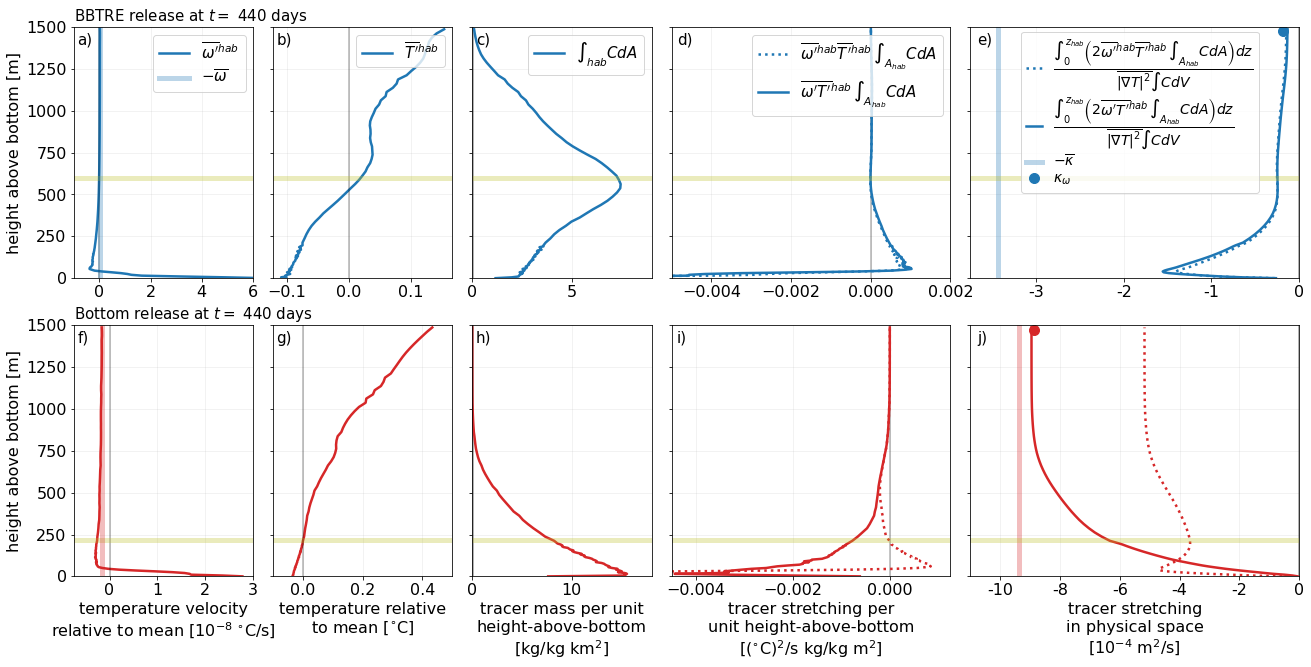

In [150]:
t = 440

scale = 1.1
fig = plt.figure(figsize=(17*scale,8.5*scale))
gs = fig.add_gridspec(2, 25)

colors = ["C0", "C3"]

axes = {
    "ω": [fig.add_subplot(gs[0, 0:4]), fig.add_subplot(gs[1, 0:4])],
    "b": [fig.add_subplot(gs[0, 4:8]), fig.add_subplot(gs[1, 4:8])],
    "C": [fig.add_subplot(gs[0, 8:12]), fig.add_subplot(gs[1, 8:12])],
    "ωbC": [fig.add_subplot(gs[0, 12:18]), fig.add_subplot(gs[1, 12:18])],
    "intωbC": [fig.add_subplot(gs[0, 18:25]), fig.add_subplot(gs[1, 18:25])],
}


for (i, tr) in enumerate([1, 3]):
    ax = axes["ω"][i]
    ds[f"ωp_Tr0{tr}_hab"].isel(time=t).plot(ax=ax, y="Z_habC_bin", label=r"$\overline{\omega^{\prime}}^{hab}$", color=colors[i], lw=2.5)
    ax.axvline(0., color="k", alpha=0.3, lw=1.5)
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("height above bottom [m]")
    ax.set_xlabel("")
    if i==1: ax.set_xlabel("temperature velocity\n"+r"relative to mean [$10^{-8}\; ^{\circ}$C/s]")
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.int64(xticks*1e8))
    ax.set_ylim([0, 1500])
    ax.set_title("")
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    ax.axvline(-ds[f"ωbar_Tr0{tr}"].isel(time=t), color=colors[i], lw=5, ls="-", alpha=0.3, label=r"$-\overline{\omega}$")
    if i==0: ax.legend(loc="upper right", fontsize=15)
    
    ax = axes["b"][i]
    ds[f"θp_Tr0{tr}_hab"].isel(time=t).plot(ax=ax, y="Z_habC_bin", label=r"$\overline{T^{\prime}}^{hab}$", color=colors[i], lw=2.5)
    ax.axvline(0., color="k", alpha=0.3, lw=1.5)
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("")
    ax.set_ylim([0, 1500])
    ax.set_title("")
    ax.set_xlabel("")
    if i==1: ax.set_xlabel("temperature relative\n"+r"to mean [$^{\circ}$C]")
    if i==0: ax.legend(loc="upper right", fontsize=15)
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    
    ax = axes["C"][i]
    ax.axvline(0., color="k", alpha=0.3, lw=3.0)
    (ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]).isel(time=t).plot(ax=ax, y="Z_habC_bin", label=r"$\int_{hab} C dA$", color=colors[i], lw=2.5)
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.int64(xticks*1e-6))
    ax.set_xlabel("")
    if i==1: ax.set_xlabel("tracer mass per unit\nheight-above-bottom\n"+r"[kg/kg km$^{2}$]")
    ax.set_ylabel("")
    ax.set_ylim([0, 1500])
    ax.set_title("")
    if i==0: ax.legend(loc="upper right", fontsize=15)
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    
    ax = axes["ωbC"][i]
    ax.axvline(0., color="k", alpha=0.3, lw=1.5)
    ((ds[f"θp_Tr0{tr}_hab"]*ds[f"ωp_Tr0{tr}_hab"])*ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]).isel(time=t).plot(ax = ax,
        y="Z_habC_bin", label=r"$\overline{\omega^{\prime}}^{hab} \overline{T^{\prime}}^{hab}\, \int_{A_{hab}} C dA$", color=colors[i], linestyle=":", lw=2.5
    )
    (ds[f"ωpθp_bar_Tr0{tr}_hab"]*ds[f"M_Tr0{tr}_hab"]/ds["dZ_habC_bin"]).isel(time=t).plot(ax = ax,
        y="Z_habC_bin", label=r"$\overline{\omega^{\prime} T^{\prime}}^{hab}\, \int_{A_{hab}} C dA$", color=colors[i], lw=2.5
    )
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("")
    ax.set_xlim([-1.5e-3,1.5e-3])
    ax.set_ylim([0, 1500])
    if i==0: ax.legend(loc="upper right", fontsize=15)
    ax.set_title("")
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    if i==1: ax.set_xlabel("tracer stretching per\nunit height-above-bottom\n"+r"[($^{\circ}$C)$^{2}$/s kg/kg m$^{2}$]")
    
    ax = axes["intωbC"][i]
    ax.axvline(0., color="k", alpha=0.3, lw=3.0)
    ((2*(ds[f"θp_Tr0{tr}_hab"]*ds[f"ωp_Tr0{tr}_hab"])*ds[f"M_Tr0{tr}_hab"]).cumsum("Z_habC_bin")/(ds[f'Gradθ**2bar_Tr0{tr}']*ds[f"M_Tr0{tr}"])).isel(time=t).plot(ax = ax,
        y="Z_habC_bin",
        label=r"$\dfrac{\int^{z_{hab}}_{0} \left( 2 \overline{\omega^{\prime}}^{hab} \overline{T^{\prime}}^{hab}\, \int_{A_{hab}} C dA \right) dz}{\overline{|\nabla T|^{2}} \int C dV}$",
        color=colors[i], linestyle=":", lw=2.5
    )
    ((2*ds[f"ωpθp_bar_Tr0{tr}_hab"]*ds[f"M_Tr0{tr}_hab"]).cumsum("Z_habC_bin")/(ds[f'Gradθ**2bar_Tr0{tr}']*ds[f"M_Tr0{tr}"])).isel(time=t).plot(ax=ax,
        y="Z_habC_bin",
        label=r"$\dfrac{\int^{z_{hab}}_{0} \left( 2 \overline{\omega^{\prime} T^{\prime}}^{hab}\, \int_{A_{hab}} C dA \right) dz}{\overline{|\nabla T|^{2}} \int C dV}$", color=colors[i], lw=2.5
    )
    ax.axvline(
        (-ds[f"κbar_Tr0{tr}"]).isel(time=t),
        color=colors[i], lw=5, ls="-", alpha=0.3, label=r"$-\overline{\kappa}$",
    )
    ax.plot(
        (ds[f"κOmega_Tr0{tr}"]).isel(time=t).values, [1475], "o",
        color=colors[i], markersize=10, label=r"$\kappa_{\omega}$",
    )
    ax.grid(True, alpha=0.2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("")
    ax.set_ylim([0, 1500])
    if i==0: ax.legend(loc="upper right", labelspacing=0.15, handlelength=1.1, fontsize=14, bbox_to_anchor=(0.3, 0.51, 0.6, 0.5))
    ax.set_title("")
    ax.axhline(ds[f"HABbar_Tr0{tr}"].isel(time=t), color="C8", lw=5, ls="-", alpha=0.3)
    if i==1: ax.set_xlabel("tracer stretching\nin physical space\n"+r"[10$^{-4}$ m$^{2}$/s]")
    
plt.tight_layout(w_pad=0.175, h_pad=1.2)

axes["ω"][0].set_title(r"BBTRE release at $t =$ 440 days", loc="left", fontsize=15)
axes["ω"][0].annotate(s="a)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["b"][0].annotate(s="b)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["C"][0].annotate(s="c)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["ωbC"][0].annotate(s="d)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["intωbC"][0].annotate(s="e)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["ω"][1].set_title(r"Bottom release at $t =$ 440 days", loc="left", fontsize=15)
axes["ω"][1].annotate(s="f)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["b"][1].annotate(s="g)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["C"][1].annotate(s="h)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["ωbC"][1].annotate(s="i)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)
axes["intωbC"][1].annotate(s="j)", xy=(0.02, 0.93), xycoords="axes fraction", fontsize=15)

axes["ω"][0].set_xlim(-1e-8, 6e-8)
axes["ω"][0].set_xticks(np.arange(0, 7, 2)*1e-8)
axes["ω"][0].set_xticklabels(np.int64(np.arange(0, 7, 2)))
axes["C"][0].set_xlim(0, 9e6)
axes["ωbC"][0].set_xlim(-5e-3, 2e-3)
axes["intωbC"][0].set_xlim(-3.75e-4, 0.)
axes["intωbC"][0].set_xticks(np.arange(-3.e-4, 1e-4, 1e-4))
axes["intωbC"][0].set_xticklabels(np.arange(-3, 1, 1))

axes["ω"][1].set_xlim(-0.75e-8, 3e-8)
axes["ω"][1].set_xticks(np.arange(0, 4, 1)*1e-8)
axes["ω"][1].set_xticklabels(np.int64(np.arange(0, 4, 1)))
axes["b"][1].set_xlim(-0.1, 0.5)
axes["C"][1].set_xlim(0, 18e6)
axes["ωbC"][1].set_xlim(-4.5e-3,1.25e-3)
axes["intωbC"][1].set_xlim(-1.1e-3, 0.)
axes["intωbC"][1].set_xticks(np.arange(-1.0e-3, 2e-4, 2e-4))
axes["intωbC"][1].set_xticklabels(np.arange(-10, 2, 2));

plt.savefig("../../figures/BBTRE-tracer/k_omega_decomposition.png", bbox_inches="tight", dpi=200.)